In [367]:
#Time series data of HD50896 from TESS - 1st part
import os, sys

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker

import numpy as np

import astropy
from astropy.io import fits
from astropy.io import ascii
import astropy.units as u
# from astropy.utils.data import get_pkg_data_filename   #time-series extraction tool
# from astropy.timeseries import TimeSeries

import math 

import lightkurve as lk    #good time-series library

import pandas as pd 

from scipy.optimize import curve_fit
from scipy.optimize import minimize

import emcee
import corner

from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum

In [488]:
#read from manually downloaded data from MAST
hd_lc1 = lk.read('tess2018349182500-s0006-0000000078959225-0126-s_lc.fits')
hd_lc1

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1468.275658949996,3.8153544e+05,6.8091309e+01,3.5933100e-03,173388,1798.22381,1148.35156,3.6825331e+05,6.5543350e+01,4.0732793e+03,1.0987913e+01,3.8153544e+05,6.8091309e+01,1000000000,nan,nan,nan,nan,1798.22381,1.9521288e-04,1148.35156,1.8575993e-04,-2.6038872e-02,-1.6257873e-02
1468.2770478816171,3.8129062e+05,6.8121017e+01,3.5933533e-03,173389,1798.22815,1148.35002,3.6847259e+05,6.5571953e+01,4.0845789e+03,1.1031659e+01,3.8129062e+05,6.8121017e+01,0,nan,nan,nan,nan,1798.22815,1.9523820e-04,1148.35002,1.8567441e-04,-2.1792805e-02,-1.8228658e-02
1468.2784368130044,3.8144528e+05,6.8116653e+01,3.5933964e-03,173390,1798.22852,1148.35194,3.6853875e+05,6.5567749e+01,4.0675962e+03,1.0985822e+01,3.8144528e+05,6.8116653e+01,0,nan,nan,nan,nan,1798.22852,1.9528455e-04,1148.35194,1.8564636e-04,-2.0513691e-02,-1.6220167e-02
1468.2798257443924,3.8147722e+05,6.8121689e+01,3.5934395e-03,173391,1798.22481,1148.34661,3.6859269e+05,6.5572594e+01,4.0734509e+03,1.0990284e+01,3.8147722e+05,6.8121689e+01,0,nan,nan,nan,nan,1798.22481,1.9530924e-04,1148.34661,1.8572700e-04,-2.3422165e-02,-2.2260994e-02
1468.2812146757808,3.8174784e+05,6.8143333e+01,3.5934825e-03,173392,1798.23023,1148.35230,3.6885275e+05,6.5593430e+01,4.0748550e+03,1.0989996e+01,3.8174784e+05,6.8143333e+01,0,nan,nan,nan,nan,1798.23023,1.9510891e-04,1148.35230,1.8568533e-04,-1.9279534e-02,-1.5657596e-02
1468.2826036074016,3.8170931e+05,6.8146454e+01,3.5935258e-03,173393,1798.23077,1148.34807,3.6886953e+05,6.5596443e+01,4.0810027e+03,1.0989873e+01,3.8170931e+05,6.8146454e+01,0,nan,nan,nan,nan,1798.23077,1.9518004e-04,1148.34807,1.8565520e-04,-1.8429298e-02,-2.0638591e-02
1468.2839925387896,3.8201750e+05,6.8169357e+01,3.5935689e-03,173394,1798.22736,1148.35035,3.6913397e+05,6.5618477e+01,4.0789397e+03,1.0992376e+01,3.8201750e+05,6.8169357e+01,0,nan,nan,nan,nan,1798.22736,1.9500872e-04,1148.35035,1.8555147e-04,-2.1759626e-02,-1.7861202e-02
1468.2853814701773,3.8202097e+05,6.8171112e+01,3.5936120e-03,173395,1798.23105,1148.35060,3.6913994e+05,6.5620171e+01,4.0569138e+03,1.1001123e+01,3.8202097e+05,6.8171112e+01,0,nan,nan,nan,nan,1798.23105,1.9511316e-04,1148.35060,1.8551630e-04,-1.8175492e-02,-1.7037949e-02


In [452]:
hd_lc1.filename

'tess2018349182500-s0006-0000000078959225-0126-s_lc.fits'

In [120]:
# hd_lc1.time.value
# pos_tab = []
# time_tab = hd_lc1.flux.value
# for i in range (len(time_tab)):
#     if math.isnan(time_tab[i]):
#         pos_tab.append(i)
# print (pos_tab)

[4179, 6169, 6170, 6171, 6172, 6173, 6174, 6175, 6176, 6177, 6178, 6179, 6180, 6181, 6182, 6183, 6184, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6200, 6201, 6202, 6203, 6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6215, 6216, 6217, 6218, 6219]


In [260]:
#detecting nan-values from light curve data
def nan_hunter(lc):
    pos_tab = []
    pdcsap_tab = lc.pdcsap_flux.value
    for i in range (len(pdcsap_tab)):
        if math.isnan(pdcsap_tab[i]):
            pos_tab.append(i)
    return pos_tab

print (nan_hunter(hd_lc1))

[]


In [439]:
#interpolating nan-values by patching them with median values from nearest neighbours - using this handy nan_helper function
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """
    return np.isnan(y), lambda z: z.nonzero()[0]

#Taking care of all nan-values of all columns (if there is any)
lc_heads = hd_lc1.colnames
print (lc_heads)
#print (np.isnan(hd_lc1.columns[13].value).all())
for i in range (len(lc_heads)):
    #print (i)
    col_dat = hd_lc1.columns[i].value
    #print (col_dat)
    if np.isnan(col_dat).all() != True:
        nans, x= nan_helper(col_dat)
        col_dat[nans]= np.interp(x(nans), x(~nans), col_dat[~nans])

#Test to see if there are nans left
print (nan_hunter(hd_lc1))

['time', 'flux', 'flux_err', 'timecorr', 'cadenceno', 'centroid_col', 'centroid_row', 'sap_flux', 'sap_flux_err', 'sap_bkg', 'sap_bkg_err', 'pdcsap_flux', 'pdcsap_flux_err', 'quality', 'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err', 'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err', 'pos_corr1', 'pos_corr2']
[]


Trying to obtain the PDCSAP flux from the time series. However, a little bit of context first.

- **SAP light curve** is summing together the brightness of pixels that fall within an aperture set by any of these survey missions - referred to as the **optimal aperture**, though, still subject to systematic artifacts of the respective mission.

- **PDCSAP light curve** has more treatment than SAP. The PDCSAP pipeline attempts to remove systematic artifacts while keeping planetary transits intact (made with planet detection intentions)

Text(0.5, 1.0, 'PDCSAP Light Curve of HD 050896 - ts1')

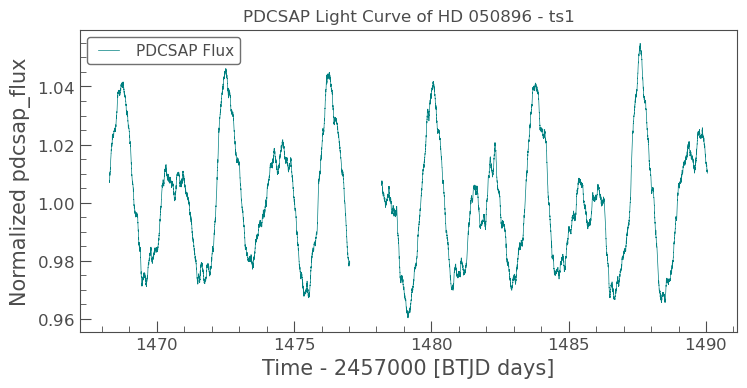

In [489]:
ax = hd_lc1.plot(column='pdcsap_flux', label='PDCSAP Flux', color='teal', normalize=True)    #PDCSAP flux
ax.set_title('PDCSAP Light Curve of HD 050896 - ts1')
#hd_lc1.plot(column='sap_flux', label='SAP Flux', color='r', normalize=True, ax=ax);    #SAP flux
#ax.set_xlim(1470, 1471)
#ax.set_ylim(1.005, 1.01)

In [6]:
#timeseries's metadata
hd_lc1.meta

{'INHERIT': True,
 'EXTNAME': 'PRIMARY',
 'EXTVER': 1,
 'SIMDATA': False,
 'TELESCOP': 'TESS',
 'INSTRUME': 'TESS Photometer',
 'OBJECT': 'TIC 78959225',
 'TICID': 78959225,
 'RADESYS': 'ICRS',
 'RA_OBJ': 103.554350353116,
 'DEC_OBJ': -23.9283389773658,
 'EQUINOX': 2000.0,
 'EXPOSURE': 17.246064015583,
 'TIMEREF': 'SOLARSYSTEM',
 'TASSIGN': 'SPACECRAFT',
 'TIMESYS': 'TDB',
 'BJDREFI': 2457000,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd',
 'TELAPSE': 21.775333353009,
 'LIVETIME': 17.246064015583347,
 'TSTART': 1468.273575668771,
 'TSTOP': 1490.048908790299,
 'DATE-OBS': '2018-12-15T18:32:47.754',
 'DATE-END': '2019-01-06T13:09:16.535',
 'DEADC': 0.792,
 'TIMEPIXR': 0.5,
 'TIERRELA': 1.16e-05,
 'INT_TIME': 1.98,
 'READTIME': 0.02,
 'FRAMETIM': 2.0,
 'NUM_FRM': 60,
 'TIMEDEL': 0.001388888888888889,
 'BACKAPP': True,
 'DEADAPP': True,
 'VIGNAPP': True,
 'GAINA': 5.21999979019165,
 'GAINB': 5.28000020980835,
 'GAINC': 5.320000171661377,
 'GAIND': 5.21999979019165,
 'READNOIA': 10.074599266052246,
 'R

### Lomb-Scargle Periodogram of HD 050896

In [490]:
#Lomb-Scargle Periodogram - normalised to parts per million
freq = np.linspace(0.1, 100, 100)
pg_hd_lc1 = hd_lc1.normalize(unit='ppm').to_periodogram()    #plot with less points
pg_hd_lc1

LombScarglePeriodogram(ID: TIC 78959225)

Text(0.5, 1.0, 'Lomb-Scargle periodogram - normal')

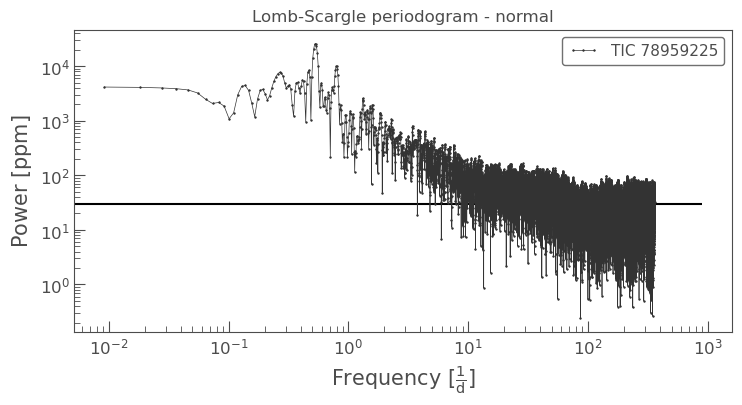

In [512]:
#Inspecting the periodogram
ax = pg_hd_lc1.plot(view='frequency', scale='log', marker='+')
#ax.hlines(29.882,0,900)
#ax.set_xlim(0,20)
ax.set_title('Lomb-Scargle periodogram - normal')
#plt.savefig('LS_lc1_log_noline')

In [514]:
pg_hd_lc1.period_at_max_power.value   #period at max power
#print (np.mean(pg_hd_lc1.power[0:10].value))
#print (np.mean(pg_hd_lc1.power[-30000:].value))

1.8769444408798894

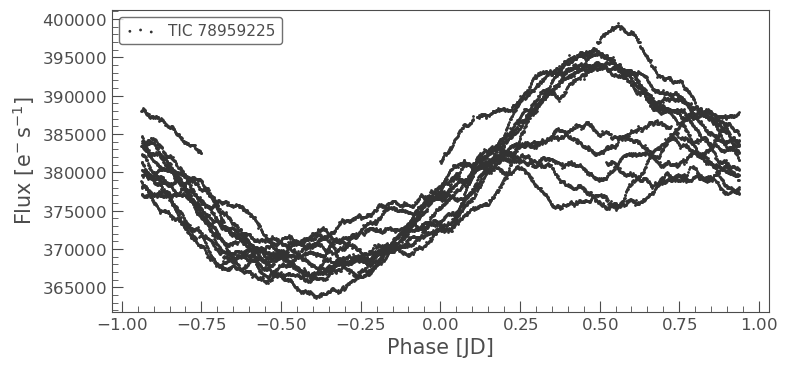

In [10]:
#Folding light curve using max power period
hd_lc1.fold(period=pg_hd_lc1.period_at_max_power).scatter()

Text(0.5, 1.0, 'WR6_lc1 - 4.03*period_max - wrap_phase = 0.2')

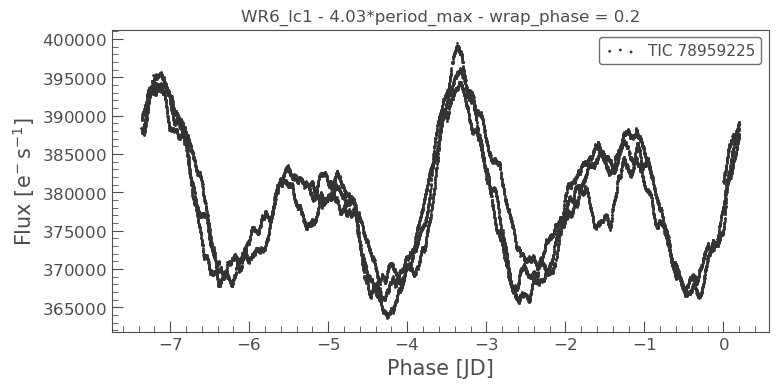

In [11]:
#Testing with folding params & then remaking periodogram
hd_lc1.fold(period=4.03*pg_hd_lc1.period_at_max_power, wrap_phase=0.2).scatter()
plt.title('WR6_lc1 - 4.03*period_max - wrap_phase = 0.2')
#plt.savefig('WR6_lc1_folded')

Hmm... Is this the best this star can do in terms of time series??? Ask Ian. 

1.8791674056716203 d


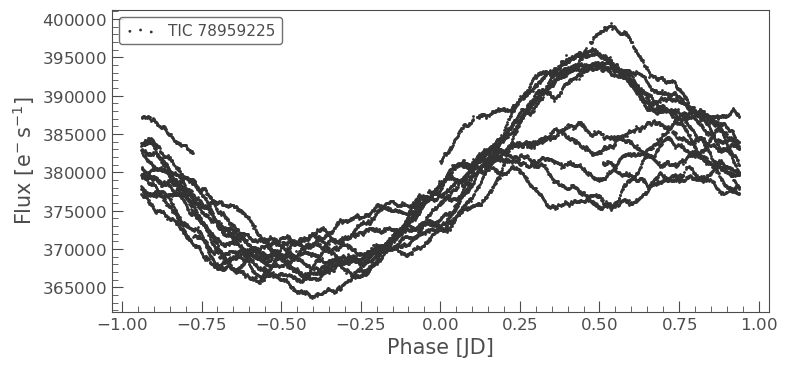

In [12]:
#Increasing oversampling frequency = 10
pg_hd_lc1 = hd_lc1.normalize(unit='ppm').to_periodogram(minimum_period=1.6*u.day, maximum_period=2*u.day, oversample_factor=10)
print(pg_hd_lc1.period_at_max_power)
hd_lc1.fold(period=pg_hd_lc1.period_at_max_power).scatter()

Text(0.5, 1.0, 'Edited LS periodogram - oversample_f = 10; min_p = 1.6 days, max_p = 2 days')

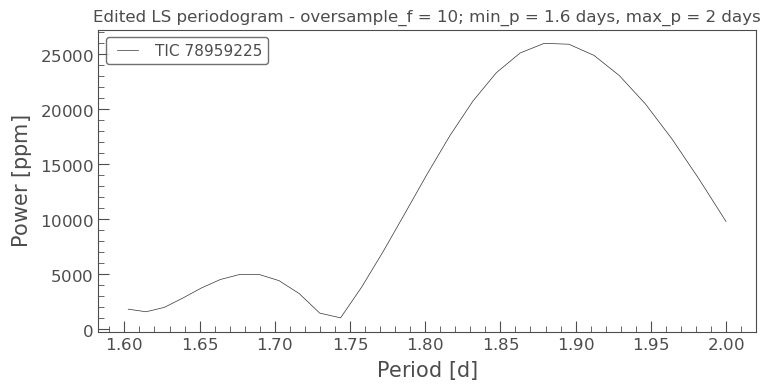

In [13]:
#Inspecting LS post-modification
ax = pg_hd_lc1.plot(view='period', scale='linear')
#ax.set_xlim(0,20)
ax.set_title('Edited LS periodogram - oversample_f = 10; min_p = 1.6 days, max_p = 2 days')

In [14]:
#Writing relevant light curves into ascii files
#hd_lc1.write("hd050896_lc1.txt", format="ascii.fixed_width", overwrite=True)


Attempt to fit Lomb-Scargle using MCMC algorithm and amplitude spectrum function from Bowman et al. (2019),

$$\alpha(\nu) = \frac{\alpha_0}{1+(\frac{\nu}{\nu_c})^\gamma} + C_w$$

where $\alpha_0$ represents the amplitude at a frequency of zero, $\gamma$ is the logarithmic amplitude gradient,
$\nu_c$ is the characteristic frequency, which is the inverse of the characteristic timescale, $\tau$, of
stochastic variability present in the light curve such that $\nu_c = (2\pi\tau)^{-1}$, and $C_w$ is a frequency-independent
(white) noise term

Text(0.5, 1.0, 'Lomb-Scargle periodogram - normal')

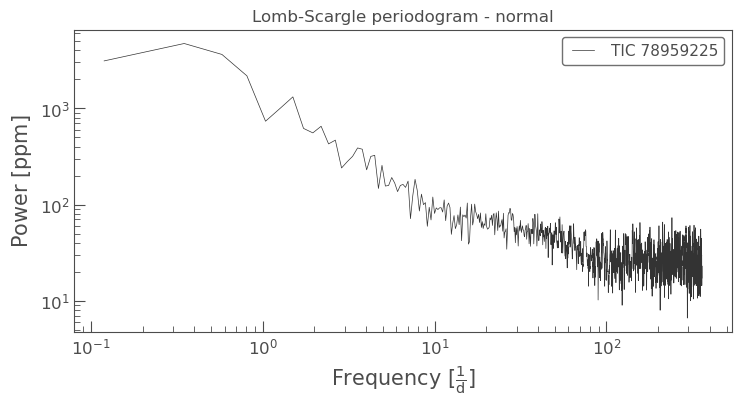

In [515]:
#Re-draw LS
short_freq = np.linspace(0.01, 100, 5000)
#pg_hd_lc1 = hd_lc1.normalize(unit='ppm').to_periodogram(frequency=short_freq)
pg_hd_lc1 = hd_lc1.normalize(unit='ppm').to_periodogram()
pg_hd_lc1 = pg_hd_lc1.bin(binsize=25, method='median')
x = getattr(pg_hd_lc1, 'frequency')   #frequency array
y = getattr(pg_hd_lc1, 'power')       #power (ppm) array

freq = [float(i/(1*x.unit)) for i in x]        #converting to scalars
amp_pow = [float(j/(1*y.unit)) for j in y]

ax = pg_hd_lc1.plot(view='frequency', scale='log')
ax.set_title('Lomb-Scargle periodogram - normal')

#print ((freq))

In [516]:
#Defining likelihood, flat prior and combined to probability
# def log_likelihood(theta, x, y):   #a1 = v_c, a2 = gamma, a3 = C_w // x = \nu
#     a0, a1, a2, a3, log_f = theta
#     model = (a0/(1+(x/a1)**a2)) + a3
#     sigma2 = model ** 2 * np.exp(2 * log_f)    #sigma is 0, not s_n
#     return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def model(theta, freq=freq):
    a0, a1, a2, a3 = theta
    return (a0/(1+(freq/a1)**a2)) + a3

def log_likelihood(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2) 

#define flat prior
def log_prior(theta):
    a0, a1, a2, a3 = theta
    if 10**3 < a0 < 10**4 and 10**-1 < a1 < 10**1 and 0 < a2 < 20 and 10**0 < a3 < 10**2:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) 

In [517]:
#Define 'true' values of a0, a1, a2, a3 and assuming an error of amplitude power
a0_true = 4*10**3
a1_true = 0.6
a2_true = 2
a3_true = 10
amp_err = 0.1*np.mean(amp_pow)

# #Optimising likelihood
# nll = lambda *args: -log_likelihood(*args)
# initial = np.array([a0_true, a1_true, a2_true, a3_true])
# soln = minimize(nll, initial, args=(freq, amp_pow, amp_err))    #minimize used here
# a0_ml, a1_ml, a2_ml, a3_ml = soln.x

# print("Maximum likelihood estimates:")
# print("a0 = {0:.3f}".format(a0_ml))
# print("a1 = {0:.3f}".format(a1_ml))
# print("a2 = {0:.3f}".format(a2_ml))
# print("a3 = {0:.3f}".format(a3_ml))
# #print("f = {0:.3f}".format(np.exp(log_f_ml)))

data = [freq, amp_pow, amp_err]
nwalkers = 120
niter = 2000
initial = np.array([a0_true, a1_true, a2_true, a3_true])
ndim = len(initial)
p0 = [np.array(initial) + 1e-6 * np.random.randn(ndim) for i in range(nwalkers)]


In [518]:
def main(p0,nwalkers,niter,ndim,log_probability,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 120)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,log_probability,data)

Running burn-in...


  0%|                                                       | 2/2000 [00:00<02:09, 15.43it/s]

Running production...


100%|████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.52it/s]


In [519]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([4.02744415e+03, 9.02983753e-01, 2.60705551e+00, 3.55103278e+01])

In [520]:
# #MCMC comes into play
# pos = soln.x + 1e-4 * np.random.randn(500, 4)
# nwalkers, ndim = pos.shape

# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, log_probability, args=(freq, amp_pow, amp_err)
# )

# #Run burn-in first
# sampler.run_mcmc(pos,100)
# sampler.reset()

# #Running production
# sampler.run_mcmc(pos, 10000, progress=True);

<ipython-input-521-394275f87fc3>:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


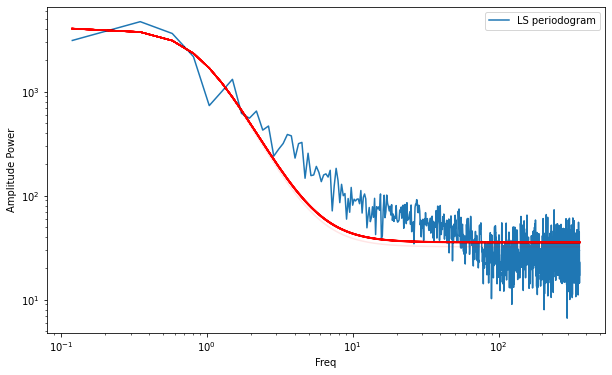

In [521]:
def plotter(sampler,freq,amp_pow):
    plt.ion()
    plt.subplots(figsize=(10, 6))
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(freq,amp_pow,label='LS periodogram')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(freq, model(theta, freq), color="r", alpha=0.1)
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Freq')
    plt.ylabel('Amplitude Power')
    plt.legend()
    plt.show()

plotter(sampler, freq, amp_pow)

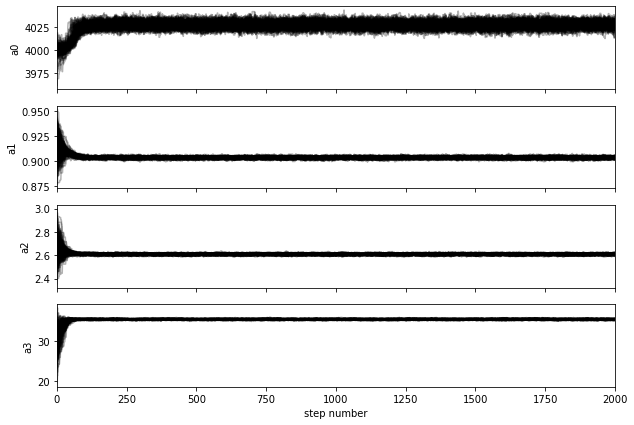

In [522]:
#Inspecting what the sampler has done
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a0", "a1", "a2", "a3"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [523]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [57.69530044 42.69572048 34.98755684 28.81467383]

In [524]:
flat_samples = sampler.get_chain(discard=120, thin=25, flat=True)
print(flat_samples.shape)

(9000, 4)


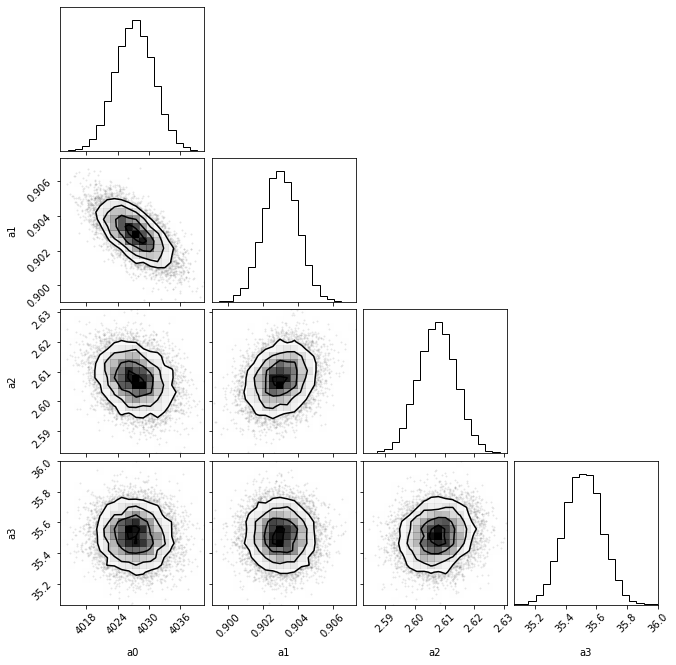

In [525]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[a0_true, a1_true, a2_true, a3_true]
);

Something is wrong with gamma, might be because there is a domination of high-frequency data points causing the gamma to be very steep. Let us try to fit our function conventionally, using curve-fit, by a smooth function (also Bowman et al. 2019) 

In [253]:
def amp_spec_func(x, a0, a1, a2, a3):
    return (a0/(1+(x/a1)**a2)) + a3

#Fitting amplitude spectrum function with LS frequencies
#Assuming a0=4400, a1=1, a2=3, a3=30
pars, cov = curve_fit(f=amp_spec_func, xdata=freq, ydata=amp_pow, p0=[4400, 1, 3, 30])
f_err = np.sqrt(np.diag(cov))
f_res = amp_pow - amp_spec_func(freq, *pars)     #residuals

print (pars, f_err)

[4.58281664e+03 9.92233339e-01 1.05429977e+02 3.83448598e+01] [5.48208462e+01 3.47719826e+04 2.02808296e+08 2.74102190e+00]


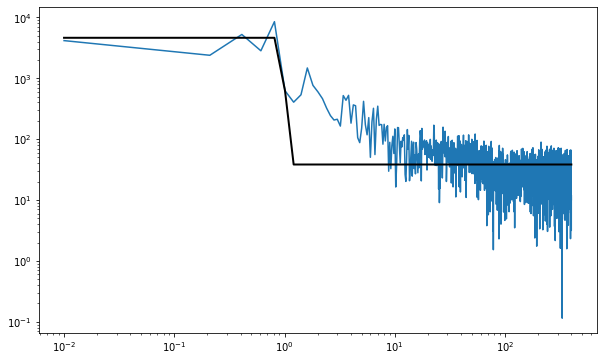

In [254]:
# Plot the fit data as an overlay on the scatter data
plt.subplots(figsize=(10, 6))
plt.yscale('log')
plt.xscale('log')
plt.plot(freq,amp_pow,label='LS periodogram')
plt.plot(freq,amp_spec_func(freq, *pars), linewidth=2, color='black')

In [83]:
type(stray_lc1)

stingray.lightcurve.Lightcurve

In [396]:
#Experiment with re-binning power spectrum with Stingray
stray_lc1 = Lightcurve.from_lightkurve(hd_lc1, skip_checks=False)
#bin_stray_lc1 = Lightcurve.make_lightcurve(stray_lc1, dt=(2/(60*24)), tstart=1468.273575668771, tseg=1490.048908790299) 
stray_lc1_ps = Powerspectrum(stray_lc1)
stray_rb_ps1 = stray_lc1_ps.rebin_log(f=0.02)
print (stray_rb_ps1.df)
print(type(stray_rb_ps1))

5.315561502308825e-07
<class 'stingray.powerspectrum.Powerspectrum'>


C:\Users\MKH\Documents\Anaconda\lib\site-packages\stingray\utils.py:126: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<ipython-input-397-a59863ad15fa>:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


[5.49393889e-07 1.08626560e-06 1.63387475e-06 2.19243608e-06
 2.76216863e-06 3.34329584e-06 3.93604559e-06 4.54065033e-06
 5.15734717e-06 5.78637795e-06 6.42798935e-06 7.08243297e-06
 7.74996546e-06 8.43084860e-06 9.12534941e-06 9.83374023e-06
 1.05562989e-05 1.12933087e-05 1.20450587e-05 1.28118437e-05
 1.35939644e-05 1.43917275e-05 1.52054459e-05 1.60354387e-05
 1.68820313e-05 1.77455557e-05 1.86263507e-05 1.95247615e-05
 2.04411406e-05 2.13758472e-05 2.23292480e-05 2.33017168e-05
 2.42936350e-05 2.53053915e-05 2.63373832e-05 2.73900147e-05
 2.84636988e-05 2.95588566e-05 3.06759176e-05 3.18153198e-05
 3.29775100e-05 3.41629440e-05 3.53720867e-05 3.66054123e-05
 3.78634044e-05 3.91465563e-05 4.04553713e-05 4.17903625e-05
 4.31520536e-05 4.45409785e-05 4.59576819e-05 4.74027194e-05
 4.88766576e-05 5.03800746e-05 5.19135599e-05 5.34777150e-05
 5.50731531e-05 5.67005000e-05 5.83603938e-05 6.00534855e-05
 6.17804391e-05 6.35419317e-05 6.53386542e-05 6.71713111e-05
 6.90406211e-05 7.094731

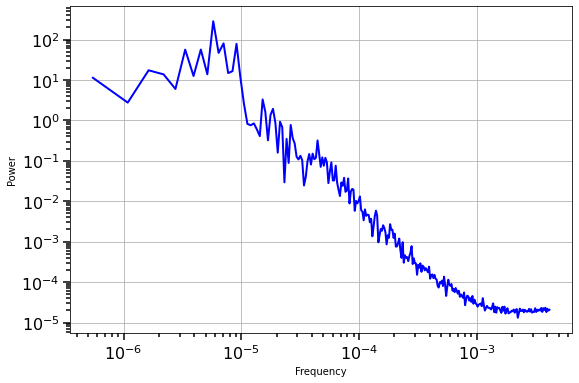

In [397]:
fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(stray_rb_ps1.freq, stray_rb_ps1.power, lw=2, color='blue')
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Power")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)

plt.show()
plt.grid()

print(stray_rb_ps1.freq)
print(stray_rb_ps1.power)

#p0=[15, 5e-6, 3, 2e-5]

[4.71557312e+01 9.79949445e-06 3.17663297e+02 9.13799336e-02] [4.40015276        nan        nan 1.06698035]


<ipython-input-253-b6cf80186d74>:2: RuntimeWarning: overflow encountered in power
  return (a0/(1+(x/a1)**a2)) + a3
<ipython-input-253-b6cf80186d74>:2: RuntimeWarning: underflow encountered in power
  return (a0/(1+(x/a1)**a2)) + a3
<ipython-input-398-c660613f628d>:7: RuntimeWarning: invalid value encountered in sqrt
  f_err = np.sqrt(np.diag(cov))
<ipython-input-253-b6cf80186d74>:2: RuntimeWarning: overflow encountered in power
  return (a0/(1+(x/a1)**a2)) + a3
<ipython-input-253-b6cf80186d74>:2: RuntimeWarning: underflow encountered in power
  return (a0/(1+(x/a1)**a2)) + a3


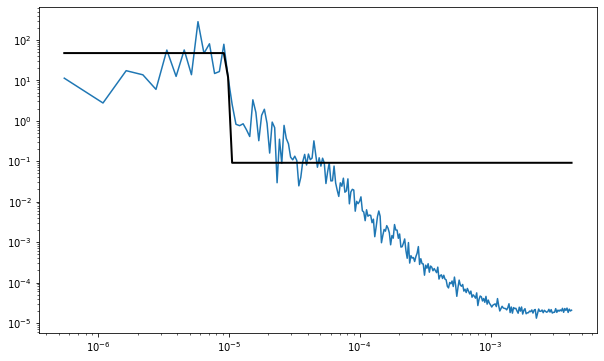

In [398]:
#Try fitting with conventional method
def log_amp_spec_func(x, a0, a1, a2, a3):  #do I have to do this?
    return np.log((a0/(1+(x/a1)**a2)) + a3)


pars, cov = curve_fit(f=amp_spec_func, xdata=stray_rb_ps1.freq, ydata=stray_rb_ps1.power, p0=[15, 1e-5, 1.5, 2e-5])
f_err = np.sqrt(np.diag(cov))
f_res = stray_rb_ps1.power - amp_spec_func(stray_rb_ps1.freq, *pars)     #residuals

print (pars, f_err)

# Plot the fit data as an overlay on the scatter data
plt.subplots(figsize=(10, 6))
plt.yscale('log')
plt.xscale('log')
plt.plot(stray_rb_ps1.freq,stray_rb_ps1.power,label='LS periodogram')
plt.plot(stray_rb_ps1.freq,amp_spec_func(stray_rb_ps1.freq, *pars), linewidth=2, color='black')

In [399]:
#Fitting with MCMC
#Redefine flat priors to match with new re-binned power spectrum
def rb_model(theta, freq=stray_rb_ps1.freq):
    a0, a1, a2, a3 = theta
    return (a0/(1+(freq/a1)**a2)) + a3

def rb_log_likelihood(theta, x, y, yerr):
    return -0.5 * np.sum(((y - rb_model(theta, x))/yerr) ** 2) 

def rb_log_prior(theta):
    a0, a1, a2, a3 = theta
    if 10**0 < a0 < 10**2 and 10**-6 < a1 < 10**-4 and 0 < a2 < 20 and 10**-5 < a3 < 10**-4:
        return 0.0
    return -np.inf

def rb_log_probability(theta, x, y, yerr):
    lp = rb_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + rb_log_likelihood(theta, x, y, yerr)

#Define 'true' values of a0, a1, a2, a3 and assuming an error of amplitude power
a0_rb = 10
a1_rb = 5e-6
a2_rb = 2
a3_rb = 2e-5
amp_err_rb = 0.05*np.mean(stray_rb_ps1.power)

rb_data = [stray_rb_ps1.freq, stray_rb_ps1.power, amp_err_rb]
nwalkers = 240
niter = 3000
initial = np.array([a0_rb, a1_rb, a2_rb, a3_rb])
ndim = len(initial)
p0 = [np.array(initial) + 1e-6 * np.random.randn(ndim) for i in range(nwalkers)]

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,rb_log_probability,rb_data)

Running burn-in...


  0%|▍                                                                                                                             | 9/3000 [00:00<00:37, 80.57it/s]

Running production...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:26<00:00, 113.77it/s]


In [400]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([4.70684950e+01, 9.85867460e-06, 1.99999914e+01, 8.87820478e-05])

<ipython-input-381-394275f87fc3>:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


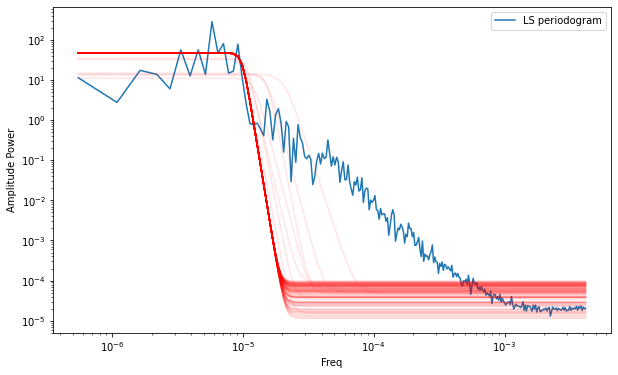

In [401]:
plotter(sampler, stray_rb_ps1.freq, stray_rb_ps1.power)

In [402]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [167.23579828 136.7900361  172.77790709  63.11322367]

In [403]:
#discard a few times the no. of steps (as burn-in) from autocorr time & thin by half-ish of it
flat_samples = sampler.get_chain(discard=250, thin=60, flat=True)
print(flat_samples.shape)

(10800, 4)


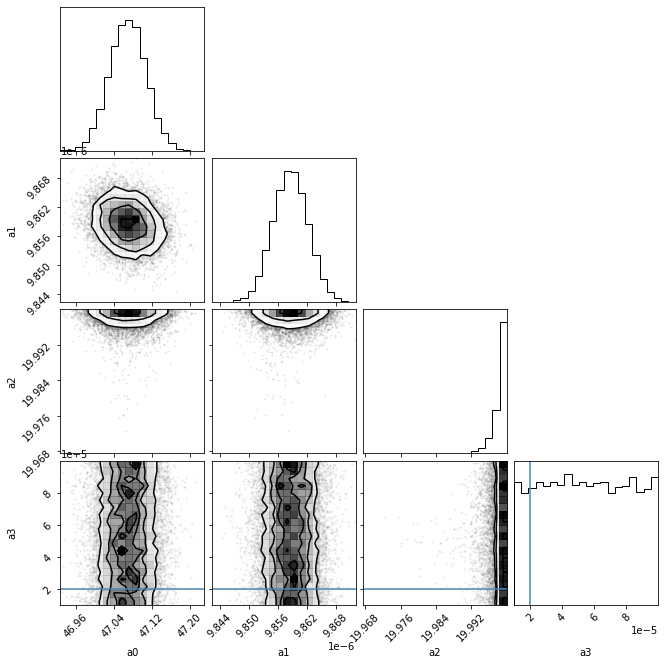

In [404]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[a0_rb, a1_rb, a2_rb, a3_rb]
);